# Which data roles and skills are associated with higher salaries?

## Data loading

In [124]:
import os
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Drop duplicates
df = df.drop_duplicates()

# Convert date to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Convert df['job_skills'] from a string to a list of strings
convert_skills = lambda x: ast.literal_eval(x) if pd.notna(x) else x
df['job_skills'] = df['job_skills'].apply(convert_skills)

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Salary distributions for top roles

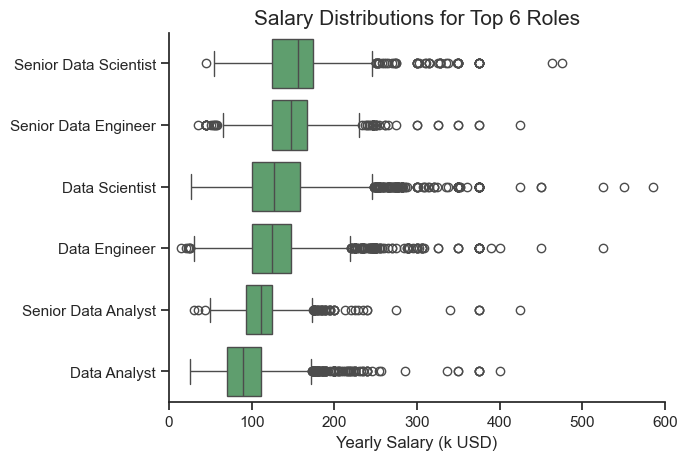

In [125]:
# Pre-filter data to only keep entries with non-null salary_year_avg
df_relevant = df.dropna(subset='salary_year_avg').copy()

# Isolate top jobs (based on total number of job postings)
n_jobs = 6
job_titles = df_relevant['job_title_short'].value_counts().index[:n_jobs].tolist()
df_top_jobs = df_relevant[df_relevant['job_title_short'].isin(job_titles)]

# Get the job order associated with descending median salary
job_order = df_top_jobs.groupby('job_title_short')['salary_year_avg'].median()
job_order = job_order.sort_values(ascending=False).index

# Plot
sns.boxplot(df_top_jobs, x='salary_year_avg', y='job_title_short',
            order=job_order, color='g')
sns.despine()

plt.title(f'Salary Distributions for Top {n_jobs} Roles', fontsize=15)
plt.xlabel('Yearly Salary (k USD)')
plt.ylabel('')
plt.xlim(0, 600000) 
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.savefig(os.path.join(output_directory, '4_1_salary_distributions.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- Median salaries increase with seniority and specialization of the roles, the highest median salary being associated with the role of senior data scientist.
- All roles present wide collections of outliers on the higher end of the salary spectrum, which may be due to varying levels of expectations (in terms of skill/responsibility) across job postings.

## Comparing salaries between highest paid skills and most requested skills

Here, we take the example of data-analyst job postings.

In [126]:
job_title = 'Data Analyst'
n_skills = 10

# Pre-filter data to only keep data-analyst entries with non-null salary_year_avg
df_relevant = df[df['job_title_short'] == job_title].copy()
df_relevant = df_relevant.dropna(subset='salary_year_avg')

# Explode job skills
df_skills = df_relevant.explode('job_skills')

# Group by job_skills and aggregate to get skill count and median salary
df_skills = df_skills.groupby('job_skills')['salary_year_avg'].agg(['count', 'median'])

# Highest paid skills
df_skills_highest_pay = df_skills.sort_values('median', ascending=False).head(n_skills)

# Most requested skills (sorted by median salary)
df_skills_most_requested = df_skills.sort_values('count', ascending=False).head(n_skills)
df_skills_most_requested = df_skills_most_requested.sort_values(by='median', ascending=False)

In [127]:
df_skills_highest_pay

,count,median
job_skills,,
svn,1,400000.0
solidity,1,179000.0
dplyr,3,167500.0
gitlab,7,163782.0
terraform,3,163782.0
couchbase,1,160515.0
datarobot,1,155485.5
golang,2,155000.0
mxnet,2,149000.0


In [128]:
df_skills_most_requested

,count,median
job_skills,,
python,1838,98500.0
tableau,1656,95000.0
r,1073,92527.5
sql,3078,92500.0
sql server,336,92150.0
power bi,1042,90000.0
sas,1006,90000.0
powerpoint,518,85000.0
excel,2135,84479.0


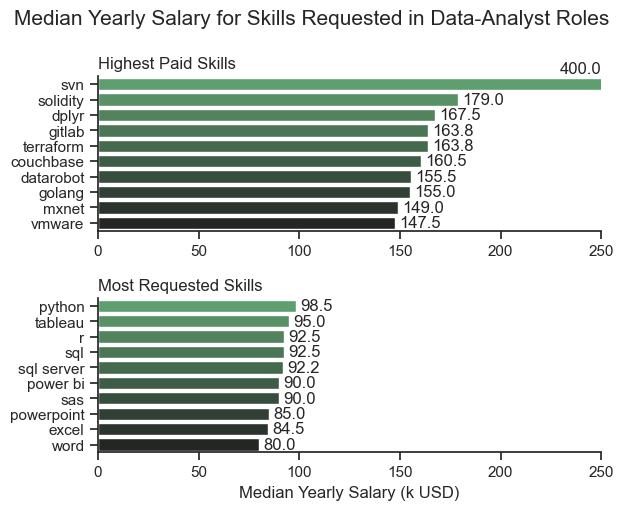

In [129]:
# Plot
fig, ax = plt.subplots(2, 1)  

job_title_plot = job_title.replace(' ', '-')

# Highest paid skills
sns.barplot(df_skills_highest_pay, x='median', y=df_skills_highest_pay.index,
            hue=df_skills_highest_pay.index, ax=ax[0], palette='dark:g_r', legend=False)
sns.despine()
ax[0].set_title('Highest Paid Skills', loc='left')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
xlim = 250000
ax[0].set_xlim([0, xlim])
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))

for idx, val in enumerate(df_skills_highest_pay['median']):
        if idx == 0:   
            ax[0].text(xlim, idx-1, f'{val/1000:.1f}', va='center', ha='right')
        else:
            ax[0].text(val+2000, idx, f'{val/1000:.1f}', va='center')  

# Most requested skills
sns.barplot(df_skills_most_requested, x='median', y=df_skills_most_requested.index,
            hue=df_skills_most_requested.index, ax=ax[1], palette='dark:g_r', legend=False)
sns.despine()
ax[1].set_title('Most Requested Skills', loc='left')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Yearly Salary (k USD)')
ax[1].set_xlim(ax[0].get_xlim())  # Set the same x-axis limits as the first plot
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))

for idx, val in enumerate(df_skills_most_requested['median']):
        ax[1].text(val+2000, idx, f'{val/1000:.1f}', va='center') 

plt.tight_layout(h_pad=1.2)
plt.suptitle(f'Median Yearly Salary for Skills Requested in {job_title_plot} Roles',
             y=1.06, fontsize=15)
plt.savefig(os.path.join(output_directory, '4_2_salary_per_skill.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The top graph, displaying the highest paid skills, was truncated because `svn` appeared as a clear outlier with a median salary of 400k USD (and a single job posting). `solidity` is also associated with a single job posting, but as a median salary of the same order as the other highest paid skills down the list. Therefore, it is not considered as an outlier _per se_.

**Breakdown:**
- Besides the `svn` outlier (in terms of salary), `solidity`, `svn` and `gitlab`/`terraform` (_ex-aequo_) are the highest paid skills, suggesting that advanced technical proficiency can lead to higher salaries.
- Although they are associated with lower median salaries, `python`, `tableau` and `r`/`sql` (_ex-aequo_) are the most requested skills.
- Most requested skills are typically associated with ~60% of the median salary characterizing the highest paid skills, which may give incentive to data analysts to develop a diverse skillset mixing fundamental and niche skills.